# Optical Character Recognition
OCR technique is used to recognize text from manuscripts or inscriptions. The Images will either be uploaded or scanned through the user interface of the application followed by implementation of the AI ML models for higher efficient performance on those uploaded images.

## Dataset creation 
- For the training of the model
- To avoid confusion between different variations of the language

In [27]:
import os
import pandas as pd

BASE_DIR = 'Img3/'
num_samples = 657

df = pd.DataFrame(columns=['img', 'class'])

for i in range(1, num_samples+1):
    sample_folder = 'Sample{:03d}/'.format(i)
    train_folder = BASE_DIR + sample_folder
    train_annotation = BASE_DIR + sample_folder
    

    

    files_in_train = sorted(os.listdir(train_folder))
    files_in_annotated = sorted(os.listdir(train_annotation))


    images = [filename for filename in files_in_train if filename in files_in_annotated]


    temp_df = pd.DataFrame()
    temp_df['img'] = [train_folder + filename for filename in images]
    temp_df['class'] = i

    df = pd.concat([df, temp_df])

df.to_csv('files_path.csv', index=False)

## Read images from CSV file
- The images are read and printed onto the screen by giving the path
- The path of the images are given in the CSV file when it was created

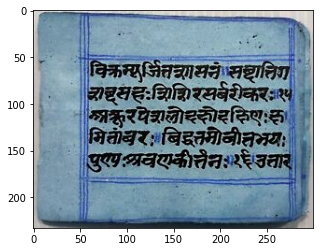

In [31]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
img = cv2.imread('san1.jpg')
plt.imshow(img)

The image is read into a variable named 'img' which is used for further computation

## Filtering of images
- Famous filters like gaussian filters are used to blur the background and contrast the images so that the model can read clearly

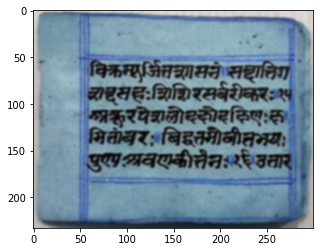

In [32]:
image_gaussian = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(image_gaussian, cmap="gray")

The values of the Gaussian function are highest at the center of the kernel and decrease towards the edges.

This process effectively blurs the image by smoothing out the high-frequency components of the image, while preserving the low-frequency components.

### Canny Edge Detection
- This is used to detect the edges of the image
- It finds the areas inside image for which the intensity changes sharply
- It highlights the boudaries of those areas

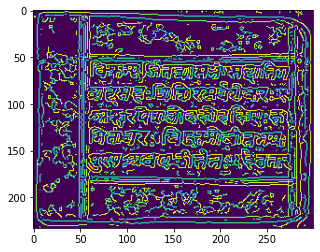

In [33]:
edges = cv2.Canny(image_gaussian, threshold1=40, threshold2=10)
plt.imshow(edges)

Note: Non-maximum suppression thins out the edges and make them more accurate. It works by suppressing all the non-maximum values in a local neighborhood of pixels around the edge.
- Need to use it only if it is feasible with the images being uploaded

### Computing the gradient of the image to find the areas of the image where the intensity changes the most
- It helps to find the areas of the image where the intensity changes the most
- Compute the gradient in x and y direction using Sobel operator

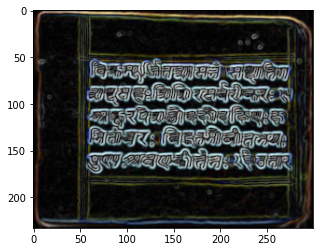

In [34]:
grad_x = cv2.Sobel(image_gaussian, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(image_gaussian, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of gradient
mag = cv2.magnitude(grad_x, grad_y)

# Normalize the magnitude to a range of 0-255 for display
mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(mag_norm)


- The magnitude of the gradient is then computed as the square root of the sum of the squares of the x and y derivatives at each pixel.
- The gradient magnitude represents the amount of change in intensity at a particular point in the image. 
- High values indicate strong edges, while low values indicate weak edges or smooth areas.

## Segmentation of the images
- The words are segregated and seperated 

In [35]:
import numpy as np
import imutils
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [36]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization
import tensorflow as tf
model = tf.keras.Sequential()
model.add(Conv2D(2048, 3, input_shape=(28 , 28 , 3), activation='relu', padding='same' , strides = [1,1]))
model.add(MaxPooling2D())

#model.add(Conv2D(64, 3, activation='relu', padding='same' , strides = [1,1]))
#model.add(MaxPooling2D())

#model.add(Conv2D(128, 3, activation='relu', padding='same' , strides = [1,1]))
#model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dropout(0.2))

model.add(Dense(256 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(657, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics = ['accuracy'])

In [37]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (84,28), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(-1,28,28,3)
        ypred = model.predict(thresh)
        #ypred = LB.inverse_transform(ypred)
        [x] = ypred
        x = np.argmax(x)
        letters.append(x)
    return letters, image

In [40]:
a,b = get_letters("san1.jpg")

1/1 [==============================] - 0s 80ms/step


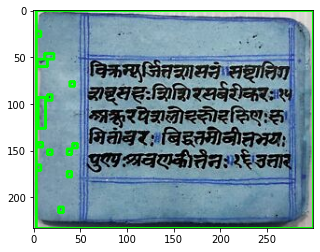

In [41]:
plt.imshow(b)

## Segment letters from images consisting of words and sentences

In [ ]:
import cv2

# Load image
img = cv2.imread('i.png')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract letters and display
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    letter = img[y:y+h, x:x+w]
    # Resize image to double the size
    resized_letter = cv2.resize(letter, (0,0), fx=30, fy=30)
    cv2.imshow('Letter', resized_letter)
    cv2.waitKey(0)

In [2]:
import cv2
import os

# Load image
img = cv2.imread('o.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a directory to store the letter images
os.makedirs('letters', exist_ok=True)

# Extract letters and save as PNG files
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    letter = img[y:y+h, x:x+w]
    # Resize image to fixed size
    resized_letter = cv2.resize(letter, (50, 50))
    # Save letter image as PNG file
    cv2.imwrite(f'letters/{i}.png', resized_letter)
